

# <center><b> Image Classification - Project 3 </b></center>
### <center><i> Group 63: Saad Shahbaz, Ria Stevens and Navneet Kaur </i></center>





## Imports

In [1]:
import pickle
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow as tf
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import random_rotation, random_zoom, random_shift, random_shear
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense

from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare data

In [3]:
TRAIN_IMAGE_PATH = "/content/drive/My Drive/Project 3 Folder/images_l.pkl"
UL_TRAIN_IMAGE_PATH = "/content/drive/My Drive/Project 3 Folder/images_ul.pkl"
TRAIN_LABEL_PATH = "/content/drive/My Drive/Project 3 Folder/labels_l.pkl"
TEST_IMAGE_PATH = "/content/drive/My Drive/Project 3 Folder/images_test.pkl"

with open(TRAIN_IMAGE_PATH, 'rb') as f: 
    training_images = pickle.load(f)

with open(TRAIN_LABEL_PATH, 'rb') as f: 
    training_labels = pickle.load(f)

with open(TEST_IMAGE_PATH, 'rb') as f: 
    test_images = pickle.load(f)

with open(UL_TRAIN_IMAGE_PATH, 'rb') as f: 
    unlabelled_training_images = pickle.load(f)

In [4]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(training_images, training_labels, test_size=0.05, random_state=42)

## Visualising Data

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


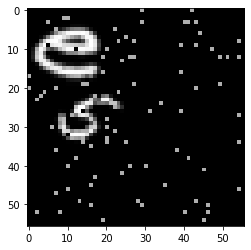

In [5]:
print(training_labels[128])
plt.imshow(training_images[128], cmap=plt.get_cmap('gray'))

## Data Augmentation

In [ ]:
def labels_to_260_classes(labels):
  class_labels = np.zeros((len(labels), 260))
  _, indices = np.where(labels == 1)
  for i in range(len(labels)):
    num = indices[2 * i]
    letter = indices[2 * i + 1]
    class_labels[i][num * 10 + letter - 10] = 1
  return class_labels

In [7]:
def augment(images):
  def augment_one(image):
    p_rot, p_shift, p_shear, p_zoom = npr.randint(low=0, high=5, size=4)
    if p_rot == 1:
      image = random_rotation(
          image, 15, row_axis=0, col_axis=1, 
          channel_axis=2, fill_mode='constant', cval=0.0
          )
    if p_shift == 1:
      image = random_shift(
          image, wrg=0.2, hrg=0.2, row_axis=0, col_axis=1, 
          channel_axis=2, fill_mode='constant', cval=0.0
          )
    if p_shear == 1:
      image = random_shear(
          image, intensity=30, row_axis=0, col_axis=1, 
          channel_axis=2, fill_mode='constant', cval=0.0
          )
    if p_zoom == 1:
      image = random_zoom(
          image, zoom_range=(0.5, 0.5), row_axis=0, col_axis=1, 
          channel_axis=2, fill_mode='constant', cval=0.0
          )
    return image
  augment_one(images[0])
  augmented_images = np.array([augment_one(image) for image in images])
  augmented_images2 = np.array([augment_one(image) for image in images])
  augmented_images3 = np.array([augment_one(image) for image in images])
  return np.concatenate([images, augmented_images, augmented_images2, augmented_images3], 0)

In [8]:
def labels_to_36_classes(labels):
  class_labels = np.zeros((len(labels), 36))
  for i in range(len(labels)):
    max_value = np.argmax(labels[i])
    class_labels[i][max_value//26] = 1
    class_labels[i][(max_value%26)+10]=1
  return class_labels

## Further Processing

In [9]:
training_labels_260 = labels_to_260_classes(train_labels)
validation_labels_260 = labels_to_260_classes(val_labels)

In [10]:
def removing_dots(input_images):

  binary_images = np.zeros(np.shape(input_images))
  for i in range(input_images.shape[0]):
    binary_images[i] = input_images[i][:, :] > 125 

  return binary_images

## Semi-Supervised Learning

In [15]:
def base_autoencoder(unlabelledX, trainX, testX):
  #define model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=3, activation='relu', use_bias=True, kernel_initializer='he_uniform', input_shape=(56, 56, 1), padding='same'))
  model.add(Conv2D(filters=1, kernel_size=3, activation='relu', use_bias=True, kernel_initializer='he_uniform', input_shape=(56, 56, 32), padding='same'))
  # compile model
  model.compile(loss='mse', optimizer=SGD(learning_rate=0.01, momentum=0.9))
  # fit model
  model.fit(unlabelledX, unlabelledX, epochs=NUM_EPOCHS, verbose=2)
  unlabelled_mse = model.evaluate(unlabelledX, unlabelledX, verbose=0)
  train_mse = model.evaluate(trainX, trainX, verbose=0)
  test_mse = model.evaluate(testX, testX, verbose=0)
  print('> reconstruction error unlabelled=%.3f, train=%.3f, test=%.3f' % (unlabelled_mse, train_mse, test_mse))
  return model

In [14]:
def evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy):
  output_layer = model.layers[-1]
  model.pop()
  for layer in model.layers:
    layer.trainable = False

  model.add(Flatten())
  model.add(Dense(36, activation='linear'))

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.fit(trainX, trainy, epochs=NUM_EPOCHS, verbose=0)

  train_acc = model.evaluate(trainX, trainy, verbose=0)
  test_acc = model.evaluate(testX, testy, verbose=0)

  model.pop()
  model.pop()
  model.add(output_layer)
  model.compile(loss='mse', optimizer=SGD(learning_rate=0.01, momentum=0.9))
  return train_acc, test_acc

In [13]:
def add_layer_to_autoencoder(model, unlabelledX, trainX, testX):
  # remember the current output layer
  output_layer = model.layers[-1]
  # remove the output layer
  model.pop()
  # mark all remaining layers as non-trainable
  for layer in model.layers:
    layer.trainable = False
  # add a new hidden layer
  model.add(Conv2D(32, 3, activation='relu', use_bias=True, kernel_initializer='he_uniform', padding='same'))
  # re-add the output layer
  model.add(output_layer)
  model.fit(unlabelledX, unlabelledX, epochs=NUM_EPOCHS, verbose=0)
  unlabelled_mse = model.evaluate(unlabelledX, unlabelledX, verbose=0)
  train_mse = model.evaluate(trainX, trainX, verbose=0)
  test_mse = model.evaluate(testX, testX, verbose=0)
  print('> reconstruction error unlabelled=%.3f, train=%.3f, test=%.3f' % (unlabelled_mse, train_mse, test_mse))

In [16]:
def combined_accuracy(y, y_hat, verbose=False, datalabel='training'):
  correct = 0
  correctNums = 0
  correctLetters = 0
  total = 0
   
  # calculate outputs by running images through the network
  numbers = y_hat[:, :10]
  predictedNums = tf.argmax(numbers, 1)
  actualNums = tf.argmax(y[:, :10], 1)
          
  letters = y_hat[:, 10:]
  predictedLetters = tf.argmax(letters, 1)
  actualLetters = tf.argmax(y[:, 10:], 1)

  boolNums = tf.equal(predictedNums, actualNums)
  intNums = tf.cast(boolNums, tf.float64)
  correctNums += tf.reduce_sum(intNums)

  boolLetters = tf.equal(predictedLetters, actualLetters)
  intLetters = tf.cast(boolLetters, tf.float64)
  correctLetters += tf.reduce_sum(intLetters)
    
  total += predictedNums.shape[0]
  correct = tf.add(tf.add(tf.multiply(intNums, intLetters), tf.scalar_mul(0.25, intNums)), tf.scalar_mul(0.25, intLetters))

  ovr_score = tf.reduce_sum(correct) / total
  ovr_acc = tf.reduce_sum(tf.multiply(intNums, intLetters)) / total
  num_acc = correctNums / total
  let_acc = correctLetters / total

  print(f'Score of the network on {datalabel} data: {ovr_score}')
  print(f'Accuracy of the network on numbers in {datalabel} data: {num_acc}')
  print(f'Accuracy of the network on letters in {datalabel} data: {let_acc}')
  print(f'Accuracy of the network on both in {datalabel} data: {ovr_acc}')

  return tf.scalar_mul(-1.0, correct)

## CNN

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(filters=16,activation='relu', kernel_size=(3,3),input_shape=(56,56,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(units=256*3*3, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=650, activation='relu'))
model.add(layers.Dense(units=260, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(x=train_images, y=training_labels_260, batch_size=15, epochs=36, verbose=1, validation_data=(val_images, validation_labels_260))

Epoch 1/36
1900/1900 [==============================] - 56s 23ms/step - loss: 4.1014 - accuracy: 0.0258 - val_loss: 4.8419 - val_accuracy: 0.0180
Epoch 2/36
1900/1900 [==============================] - 42s 22ms/step - loss: 3.7005 - accuracy: 0.0309 - val_loss: 3.7711 - val_accuracy: 0.0313
Epoch 3/36
1900/1900 [==============================] - 43s 22ms/step - loss: 3.6311 - accuracy: 0.0322 - val_loss: 3.6501 - val_accuracy: 0.0353
Epoch 4/36
1900/1900 [==============================] - 43s 23ms/step - loss: 3.5639 - accuracy: 0.0411 - val_loss: 3.4913 - val_accuracy: 0.0553
Epoch 5/36
1900/1900 [==============================] - 43s 22ms/step - loss: 3.4372 - accuracy: 0.0575 - val_loss: 3.2744 - val_accuracy: 0.0773
Epoch 6/36
1900/1900 [==============================] - 43s 22ms/step - loss: 3.2902 - accuracy: 0.0685 - val_loss: 3.3860 - val_accuracy: 0.0607
Epoch 7/36
1900/1900 [==============================] - 43s 22ms/step - loss: 3.1189 - accuracy: 0.0912 - val_loss: 2.9463 -

## Visualising the output

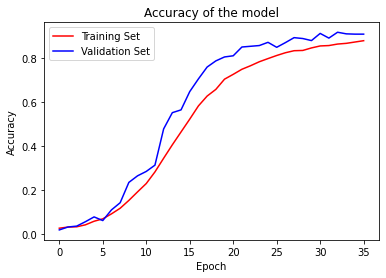

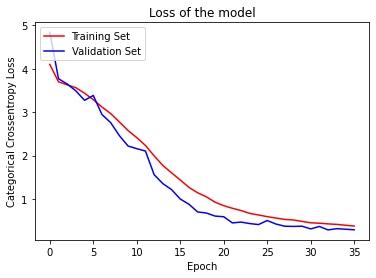

In [22]:
model_accuracy_training = history.history['accuracy']
model_loss_training = history.history['loss']
model_accuracy_validation = history.history['val_accuracy']
model_loss_validation = history.history['val_loss']
plt.plot(model_accuracy_training, color='Red')
plt.plot(model_accuracy_validation, color = 'Blue')
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_loss_training,color='Red')
plt.plot(model_loss_validation, color = 'Blue')
plt.title('Loss of the model')
plt.ylabel('Categorical Crossentropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

## Running on Test Data

In [17]:
test_predictions = np.array(model.predict(test_images))

In [19]:
testing_labels = labels_to_36_classes(test_predictions)

In [20]:
print(testing_labels[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Dictionary For Labels

In [18]:
values = {
    0:'0', 
    1:'1',
    2:'2', 
    3:'3', 
    4:'4',
    5:'5', 
    6:'6', 
    7:'7', 
    8:'8', 
    9:'9', 
    10:'A', 
    11:'B', 
    12:'C', 
    13:'D', 
    14:'E',
    15:'F',
    16:'G',
    17:'H',
    18:'I',
    19:'J',
    20:'K',
    21:'L',
    22:'M',
    23:'N',
    24:'O',
    25:'P',
    26:'Q',
    27:'R',
    28:'S',
    29:'T',
    30:'U',
    31:'V',
    32:'W',
    33:'X',
    34:'Y',
    35:'Z'
}
  


## Visualising Some Outputs

In [21]:
pred_strings = []
for pred in testing_labels:
    st = "".join([str(int(x)) for x in pred])
    pred_strings.append(st)

In [31]:
import random
#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(0, len(pred_strings)-1), 10)
print(randomlist)

[3526, 13052, 9845, 10785, 6497, 13335, 2400, 11713, 14228, 14857]


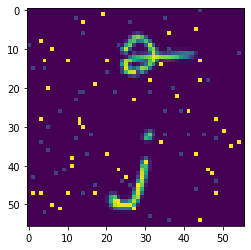

2 J


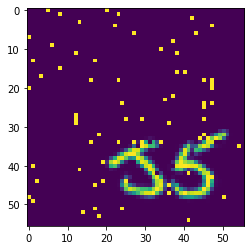

5 J


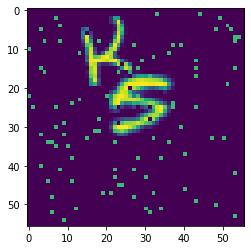

5 K


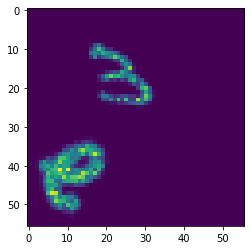

3 E


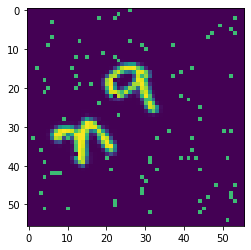

9 N


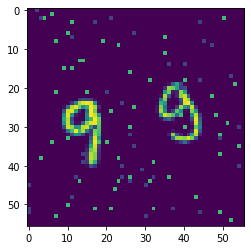

9 G


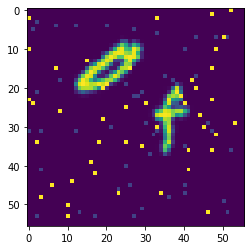

0 F


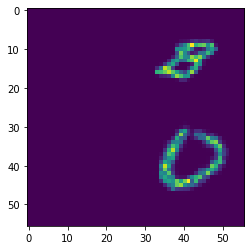

0 B


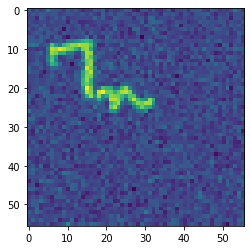

7 N


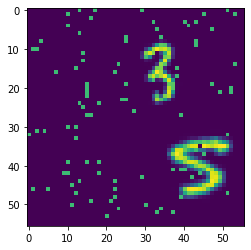

3 S


In [32]:
for i in range(len(randomlist)):
  pred = pred_strings[randomlist[i]]
  plt.imshow(test_images[randomlist[i]])
  plt.show()
  num = pred.index("1")
  let = pred[10:].index("1") + 10
  print(values[num], values[let])